# TF Hub

https://tfhub.dev/

In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build([None, 256, 256, 3])  # Batch input shape.

adam = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [3]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),  
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        invalid_filnames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name'].isin(invalid_filnames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        final = (idx + 1) * self.batch_size
        data = self.df.iloc[start:final]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg') # f는 f-string 문자열 포매팅
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
                
            image = image.astype('float32')
            image = image / 255.
        
            label = int(r['species']) - 1 # 고양이 1, 개 2 이므로 1 빼줌
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [5]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=64,
    image_size=256,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=64,
    image_size=256,
    shuffle=True
)

In [6]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
92/92 [==============================] - 562s 6s/step - loss: 0.1872 - accuracy: 0.9471 - val_loss: 0.0298 - val_accuracy: 0.9925
Epoch 2/10
92/92 [==============================] - 576s 6s/step - loss: 0.0317 - accuracy: 0.9903 - val_loss: 0.0154 - val_accuracy: 0.9932
Epoch 3/10
92/92 [==============================] - 541s 6s/step - loss: 0.0148 - accuracy: 0.9971 - val_loss: 0.0089 - val_accuracy: 0.9966
Epoch 4/10
92/92 [==============================] - 537s 6s/step - loss: 0.0090 - accuracy: 0.9976 - val_loss: 0.0131 - val_accuracy: 0.9959
Epoch 5/10
92/92 [==============================] - 542s 6s/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0054 - val_accuracy: 0.9993
Epoch 6/10
92/92 [==============================] - 571s 6s/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 0.0067 - val_accuracy: 0.9973
Epoch 7/10
92/92 [==============================] - 586s 6s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0091 - val_accuracy: 0.9966
Epoch 8/10
92

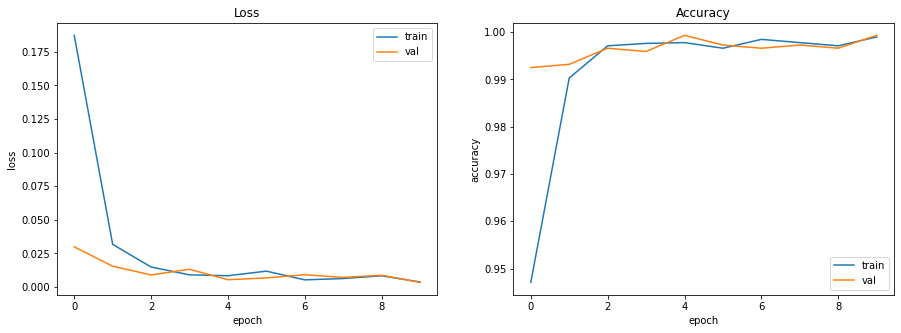

In [7]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()